# Movie Recommendation Engine Using Cosine Similarity

#### Steps Involved

1. Import all the libraries
2. Import dataset(s)
3. Merge the dataset based on common feature
4. Create Pivot table
5. Create a Sparse Matrix
6. Build an nearest neighbor model based on cosine similarity between movies

## 1. Import Modules

In [1]:
import pandas as pd
import numpy as np

from scipy.sparse import csr_matrix
from sklearn.neighbors import NearestNeighbors

## 2. Load dataset

In [2]:
movies_df = pd.read_csv('movies.csv')
rating_df = pd.read_csv('ratings.csv')

In [3]:
movies_df.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [4]:
rating_df.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [5]:
print('Movies Dataframe shape : ', movies_df.shape)
print('Rating Dataframe shape : ', rating_df.shape)

Movies Dataframe shape :  (9742, 3)
Rating Dataframe shape :  (100836, 4)


In [6]:
movies_df.isna().any()

movieId    False
title      False
genres     False
dtype: bool

In [7]:
rating_df.isna().any()

userId       False
movieId      False
rating       False
timestamp    False
dtype: bool

In [8]:
movies_df.duplicated().sum()

0

In [9]:
rating_df.duplicated().sum()

0

## 3. Merge the movie and rating dataset

In [10]:
merged_df = pd.merge(rating_df, movies_df, on='movieId')
merged_df.head()

,userId,movieId,rating,timestamp,title,genres
0,1,1,4.0,964982703,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,5,1,4.0,847434962,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
2,7,1,4.5,1106635946,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
3,15,1,2.5,1510577970,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
4,17,1,4.5,1305696483,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy


In [11]:
merged_df.drop(['timestamp', 'genres'], axis = 1, inplace = True)

In [12]:
merged_df.shape

(100836, 4)

In [13]:
merged_df.duplicated().sum()

0

In [14]:
merged_df.head()

,userId,movieId,rating,title
0,1,1,4.0,Toy Story (1995)
1,5,1,4.0,Toy Story (1995)
2,7,1,4.5,Toy Story (1995)
3,15,1,2.5,Toy Story (1995)
4,17,1,4.5,Toy Story (1995)


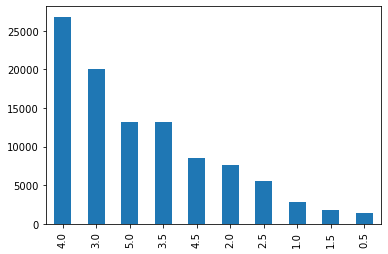

In [15]:
merged_df['rating'].value_counts().plot(kind = 'bar')

## 4. Create Pivot Table

In [16]:
movie_features_df = merged_df.pivot_table(index = 'title',columns = 'userId',values = 'rating')
movie_features_df.head()

userId,1,2,3,4,5,6,7,8,9,10,...,601,602,603,604,605,606,607,608,609,610
title,,,,,,,,,,,,,,,,,,,,,
'71 (2014),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0
'Hellboy': The Seeds of Creation (2004),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
'Round Midnight (1986),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
'Salem's Lot (2004),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
'Til There Was You (1997),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [17]:
movie_features_df.shape

(9719, 610)

In [18]:
missing_value_col_wise_count = movie_features_df.isna().sum()
missing_value_col_wise_count

userId
1      9487
2      9690
3      9680
4      9503
5      9675
       ... 
606    8604
607    9532
608    8888
609    9682
610    8417
Length: 610, dtype: int64

#### Observation:

movie_features_df is a sparse matrix and most of the columns have 1000+ empty cells

In [19]:
# sparsity_of_matrix = count zero elements / total elements

rows = movie_features_df.shape[0]
cols = movie_features_df.shape[1]

count_empty_or_zero_cells = movie_features_df.isna().sum().sum()
total_elements = rows * cols

sparsity_of_matrix = count_empty_or_zero_cells/total_elements

print('Total Empty cells are : ', count_empty_or_zero_cells)
print('Total cells in Matrix are : ', total_elements)
print('Sparsity of Matrix are : ', sparsity_of_matrix)

Total Empty cells are :  5827758
Total cells in Matrix are :  5928590
Sparsity of Matrix are :  0.9829922460483859


In [20]:
movie_features_df.fillna(0, inplace = True)

In [21]:
movie_features_df.values

array([[0. , 0. , 0. , ..., 0. , 0. , 4. ],
       [0. , 0. , 0. , ..., 0. , 0. , 0. ],
       [0. , 0. , 0. , ..., 0. , 0. , 0. ],
       ...,
       [0. , 0. , 0. , ..., 0. , 0. , 1.5],
       [4. , 0. , 0. , ..., 0. , 0. , 0. ],
       [0. , 0. , 0. , ..., 0. , 0. , 0. ]])

## 5. Create Sparse Matrix from Pivot table

#### Sparse Matrix Example : https://machinelearningmastery.com/sparse-matrices-for-machine-learning/

In [22]:
# create dense matrix

A = np.array([[1, 0, 0, 1, 0, 0], [0, 0, 2, 0, 0, 1], [0, 0, 0, 2, 0, 0]])
print('Dense Matrix A :\n\n', A)
print('*'*20)
print()

# convert to sparse matrix (CSR method)

S = csr_matrix(A)
print('Sparse or CSR Matrix S :\n\n', S)
print('*'*20)
print()

# reconstruct dense matrix

B = S.todense()
print('Dense Matrix B :\n\n', B)

Dense Matrix A :

 [[1 0 0 1 0 0]
 [0 0 2 0 0 1]
 [0 0 0 2 0 0]]
********************

Sparse or CSR Matrix S :

   (0, 0)	1
  (0, 3)	1
  (1, 2)	2
  (1, 5)	1
  (2, 3)	2
********************

Dense Matrix B :

 [[1 0 0 1 0 0]
 [0 0 2 0 0 1]
 [0 0 0 2 0 0]]


In [23]:
from scipy.sparse import csr_matrix

movie_features_df_matrix = csr_matrix(movie_features_df.values)

## 6. Build NearestNeighbors model based on cosine similarity

### Cosine Similarity

<img src="cosine similarity.png">

In [24]:
from sklearn.neighbors import NearestNeighbors

nearest_neighbor_model = NearestNeighbors(metric = 'cosine', algorithm = 'brute')
nearest_neighbor_model.fit(movie_features_df_matrix)

NearestNeighbors(algorithm='brute', metric='cosine')

## 7. Select some random movie

In [25]:
total_no_of_moives = movie_features_df.shape[0]
print('Total Movies in our pivot table : ', total_no_of_moives)
print()

random_movie_index = np.random.choice(total_no_of_moives)
print('Random Moive Index : ', random_movie_index)

Total Movies in our pivot table :  9719

Random Moive Index :  4827


In [26]:
movie_features_df.iloc[random_movie_index]

userId
1      0.0
2      0.0
3      0.0
4      0.0
5      0.0
      ... 
606    0.0
607    0.0
608    0.0
609    0.0
610    0.0
Name: Knockin' on Heaven's Door (1997), Length: 610, dtype: float64

## 8. One dimenesional vector representation of random movie

In [27]:
one_dimensional_representation_of_movie_vector = movie_features_df.iloc[random_movie_index].values.reshape(1, -1)
one_dimensional_representation_of_movie_vector

array([[0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
        0. , 0. , 0. , 0. , 3.5, 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
        0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
        0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
        0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
        0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
        0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
        0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
        5. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
        0. , 0. , 0. , 0. , 0. , 0. , 0. , 4. , 0. , 0. , 0. , 0. , 0. ,
        0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
        0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
        0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
        0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. 

## 9. Similar movie for our random movie based on cosine distance

#### Find the similar movie for some random movie from our dataset

In [28]:
distances, indices = nearest_neighbor_model.kneighbors(one_dimensional_representation_of_movie_vector, n_neighbors = 6)

In [29]:
print('Distance :', distances)
print('Indices :', indices)

Distance : [[1.11022302e-16 2.54130146e-01 2.96051817e-01 2.98931816e-01
  3.55168580e-01 3.58227575e-01]]
Indices : [[4827 6219 1823 4742 9667 4306]]


In [30]:
indices = indices.flatten()
distances = distances.flatten()

for i in range(0, len(indices)):
    ## same movie
    if i == 0:
        print('Recommendations for {0}:\n'.format(movie_features_df.index[random_movie_index]))
    else:
        ## similar movies
        print('{0}: {1}, with distance of {2}'.format(i, movie_features_df.index[indices[i]], distances[i]))

Recommendations for Knockin' on Heaven's Door (1997):

1: Nymphomaniac: Volume I (2013), with distance of 0.2541301460171086
2: Class, The (Klass) (2007), with distance of 0.2960518166767325
3: Kill the Irishman (2011), with distance of 0.29893181598402596
4: Your Name. (2016), with distance of 0.3551685800633959
5: In the Heart of the Sea (2015), with distance of 0.3582275749828461


#### Find the similar movie for all movies in our dataset

In [56]:
my_dict = {}
for movie_index in range(movie_features_df.shape[0]):
    
    one_dimensional_representation_of_movie_vector = movie_features_df.iloc[movie_index].values.reshape(1, -1)
    distances, indices = nearest_neighbor_model.kneighbors(one_dimensional_representation_of_movie_vector, n_neighbors = 4)
    indices = indices.flatten()
    distances = distances.flatten()
    similar_movies = []
    
    for i in range(0, len(indices)):
        ## same movie
        if i == 0:
            original_movie = movie_features_df.index[movie_index]
        else:
            ## similar movies
            similar_movies.append(movie_features_df.index[indices[i]])

        my_dict[original_movie] = similar_movies
        

In [58]:
recommended_movie_df = pd.DataFrame(my_dict)
recommended_movie_df = recommended_movie_df.T
recommended_movie_df.columns = ['1st_Similar_Movie', '2nd_Similar_Movie', '3rd_Similar_Movie']

recommended_movie_df.head()

,1st_Similar_Movie,2nd_Similar_Movie,3rd_Similar_Movie
'71 (2014),Digimon: The Movie (2000),Tokyo Tribe (2014),Invincible Shaolin (1978)
'Hellboy': The Seeds of Creation (2004),Space Battleship Yamato (2010),Monsters (2010),All the Right Moves (1983)
'Round Midnight (1986),"Agony and the Ecstasy, The (1965)","Asphyx, The (1973)","Angry Red Planet, The (1959)"
'Salem's Lot (2004),"All This, and Heaven Too (1940)",'Til There Was You (1997),Absence of Malice (1981)
'Til There Was You (1997),"All This, and Heaven Too (1940)",'Salem's Lot (2004),Absence of Malice (1981)


In [77]:
movie_name = input('What movie you recently watched?\n')
print()
print()

result = recommended_movie_df.loc[movie_name, : ]
print('I have movie recommendatation for you: \n')
for movies in list(result.values):
      print(movies)


What movie you recently watched?
Knockin' on Heaven's Door (1997)


I have movie recommendatation for you: 

Nymphomaniac: Volume I (2013)
Class, The (Klass) (2007)
Kill the Irishman (2011)
